In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
from multiobjective_opt.synthetic_exp.function_handler import JaxFunc
from multiobjective_opt.synthetic_exp.mabs import UCB  # , Greedy
from multiobjective_opt.synthetic_exp.optimizers import (
    AcceleratedGradDescent,
    Constraints,
    SGMTripleAveraging,
)
from multiobjective_opt.utils import savefig
from scipy.optimize import Bounds

In [2]:
def check_optimality(arms, T=1000):
    pulls_history = []
    bounds_history = []
    for i in range(T):
        confidence_bounds = [a.bounds() for a in arms]

        best_vals = [arm.step() for arm in arms]

        pulls_history.append(best_vals)
        bounds_history.append(confidence_bounds)

    pulls_history = np.array(pulls_history).T
    bounds_history = np.array(bounds_history).T
    pulls_history.shape

    from cProfile import label

    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    colors = ["b", "g", "r", "black"]
    for arm, p_h, c_b, color in zip(arms, pulls_history, bounds_history, colors):
        a_n = arm.name
        x = np.arange(len(p_h))
        ax.plot(x, p_h, label=a_n, color=color)
        ax.fill_between(
            x,
            y1=p_h - c_b,
            y2=p_h,
            color=color,
            alpha=0.1,
        )

    ax.set_xlabel(r"$\#$ Iteration")
    ax.set_ylabel(r"$f(x)$")
    plt.legend()
    return fig

## не стохастический градиент

В этом эксперименте рассмотрим функции с доступом к точному градиенту.

Среди функций будут сильно выпуклые, гладкие выпуклые и негладкие выпуклые. 

1) Для сильно реализуется ускоренный градиентный спуск сходимостью $1/t^2$.
3) Для негладких применим технику сглаживания и получим сходимость порядка $1/t^{0.5}$


oracle_smooth = 

In [26]:
from multiobjective_opt.synthetic_exp.functions import (
    LinearFunc,
    ModularFunc,
    QuadForm,
    QuadFormNotStrongly,
    QuadFormSQRT,
)


def get_QuadFormSQRT_arm(dim_smooth, min_val=None):
    if min_val is None:
        min_val = np.random.randn()

    oracle_smooth = JaxFunc(QuadFormSQRT(dim_smooth, min_val=min_val), dim_smooth)
    x0 = np.ones(dim_smooth) * 4
    L, R = oracle_smooth.func.get_params(x0)
    L = L
    smooth_optimizer = AcceleratedGradDescent(oracle_smooth, x0=x0, L=L, R=R)
    smooth_optimizer.name = f"Quad form. AGD. min={min_val}"
    return smooth_optimizer


def get_smooth_arm(dim_smooth, min_val=None):
    if min_val is None:
        min_val = np.random.randn()

    oracle_smooth = JaxFunc(QuadFormNotStrongly(dim_smooth, min_val=min_val), dim_smooth)
    x0 = np.ones(dim_smooth) * 2
    L, R = oracle_smooth.func.get_params(x0)
    L = L * 2
    smooth_optimizer = AcceleratedGradDescent(oracle_smooth, x0=x0, L=L, R=R)
    smooth_optimizer.name = f"Quad form. AGD. min={min_val}"
    return smooth_optimizer


def get_nonsmooth_arm(dim_nonsmooth, min_val=None):
    bounds = Bounds(-np.ones(dim_nonsmooth) * 4, np.ones(dim_nonsmooth) * 4)
    projection_function = Constraints(bounds=bounds)

    if min_val is None:
        min_val = np.random.randn()

    oracle_nonsmooth = JaxFunc(
        ModularFunc(
            dim_nonsmooth, optimization_set=bounds, min_val=min_val, num_planes=2
        ),
        dim_nonsmooth,
    )
    x0 = np.zeros(dim_nonsmooth)
    L_nonsmooth, R = oracle_nonsmooth.func.get_params(x0)
    G = 8 * dim_nonsmooth**0.5
    G = R
    nonsmooth_optimizer = SGMTripleAveraging(
        oracle_nonsmooth,
        projection_function=projection_function,
        gamma=L_nonsmooth,
        L=L_nonsmooth,
        G=G,
        dimension=dim_nonsmooth,
    )
    nonsmooth_optimizer.name = f"Lin form. SGMTA. min={min_val}"
    return nonsmooth_optimizer


def init_arms():
    dim = 4
    smooth_arms = 1
    nonsmooth_arms = 3
    smooth_arms_val = [2.0]

    nonsmooth_arms_values = np.linspace(2, 6, num=nonsmooth_arms)

    arms = []

    for i in range(nonsmooth_arms):
        nsm_opt = get_nonsmooth_arm(dim, nonsmooth_arms_values[i])
        arms.append(nsm_opt)

    for i in range(smooth_arms):
        sm_opt = get_smooth_arm(dim, smooth_arms_val[i])
        arms.append(sm_opt)
    return arms

In [27]:
def init_quad_arms():
    num_arms = 5
    dim = 50
    arm_min_vals = np.linspace(1, 3, num=num_arms)

    arms = []

    for i in range(num_arms):
        nsm_opt = get_QuadFormSQRT_arm(dim, arm_min_vals[i])
        arms.append(nsm_opt)
    return arms


arms = init_quad_arms()
alg = UCB(arms)
alg_res = alg.run(T=200)

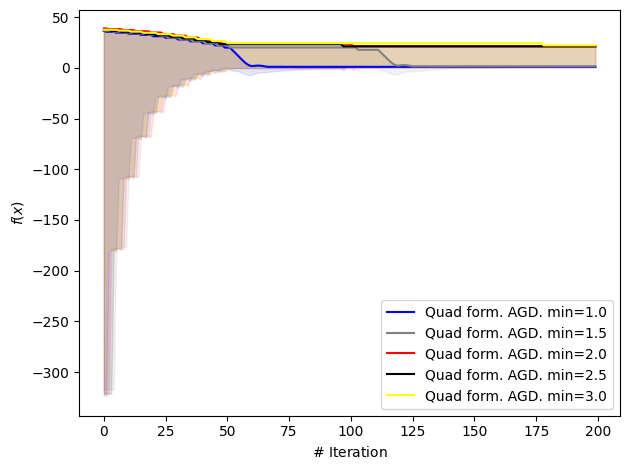

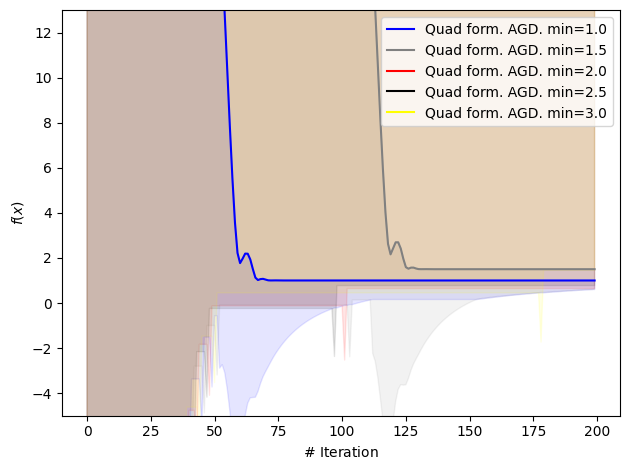

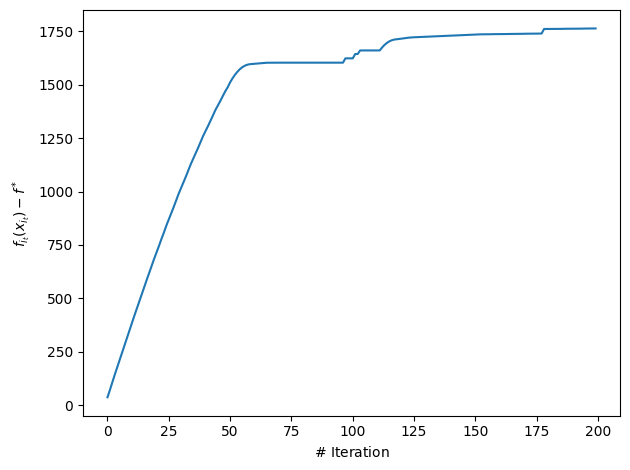

In [28]:
figs = {}
colors = ["b", "gray", "r", "black", "yellow"]
figs["running"] = alg_res.draw_all_steps(arms, colors=colors)
figs["running_clipped"] = alg_res.draw_all_steps(arms, colors=colors, ylim=[-5, 13])
figs["cumulative"] = alg_res.draw_cumulative_regret(1)

In [6]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "nonstochastic_smooth"
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)

In [32]:
def init_arms():
    dim = 40
    smooth_arms = 0
    nonsmooth_arms = 5
    smooth_arms_val = [2.0]

    nonsmooth_arms_values = np.linspace(2, 6, num=nonsmooth_arms)

    arms = []

    for i in range(nonsmooth_arms):
        nsm_opt = get_nonsmooth_arm(dim, nonsmooth_arms_values[i])
        arms.append(nsm_opt)

    for i in range(smooth_arms):
        sm_opt = get_smooth_arm(dim, smooth_arms_val[i])
        arms.append(sm_opt)
    return arms


arms = init_arms()
alg = UCB(arms)
alg_res = alg.run(T=1000)

-189.67279052734375
-200.94944763183594
-148.0154571533203
-140.59352111816406
-173.7889404296875


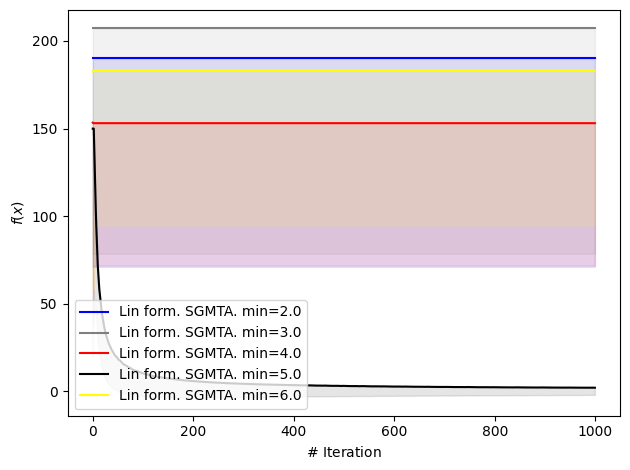

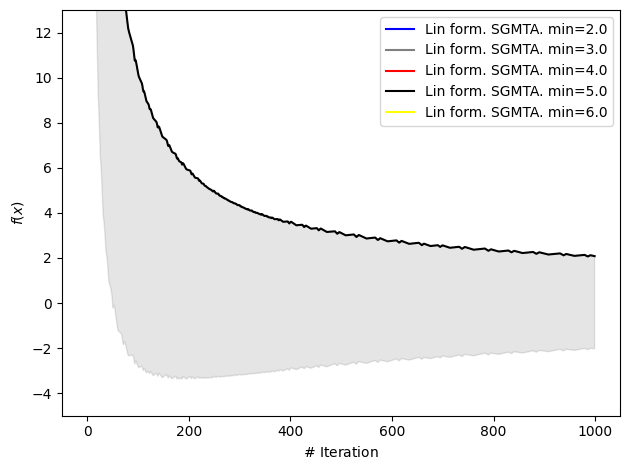

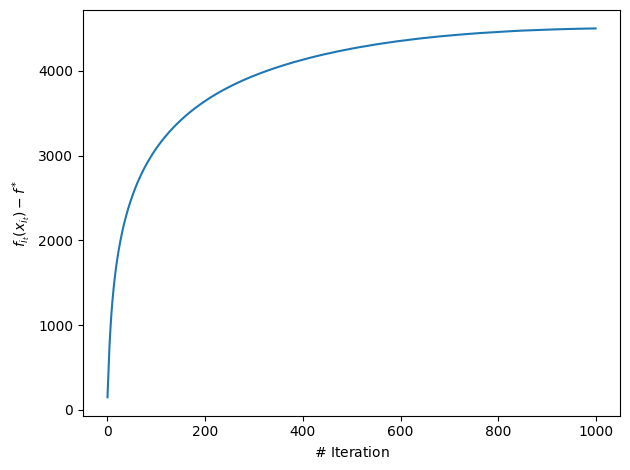

In [33]:
figs = {}
colors = ["b", "gray", "r", "black", "yellow"]
figs["running"] = alg_res.draw_all_steps(arms, colors=colors)
figs["running_clipped"] = alg_res.draw_all_steps(arms, colors=colors, ylim=[-5, 13])
figs["cumulative"] = alg_res.draw_cumulative_regret(2)

In [34]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "nonstochastic_nonsmooth"
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)

Рассмотрим стохастический градиент

In [36]:
from multiobjective_opt.synthetic_exp.function_handler import NormalRandomizer
from multiobjective_opt.synthetic_exp.functions import (
    LinearFunc,
    ModularFunc,
    QuadForm,
    QuadFormNotStrongly,
    QuadFormSQRT,
)
from multiobjective_opt.synthetic_exp.optimizers import StochasticAGD


def get_stochastoc_arm(dim_smooth, min_val=None, sigma=1):
    if min_val is None:
        min_val = np.random.randn()

    bounds = Bounds(-np.ones(dim_smooth) * 4, np.ones(dim_smooth) * 4)
    projection_function = Constraints(bounds=bounds)

    grad_randomizer = NormalRandomizer(dim=dim_smooth, sigma=sigma)
    oracle_smooth = JaxFunc(
        # QuadFormNotStrongly(dim_smooth, min_val=min_val),
        QuadFormSQRT(dim_smooth, min_val=min_val),
        dim_smooth,
        grad_randomizer=grad_randomizer,
    )
    x0 = np.ones(dim_smooth) * 2
    Lipshitz, R = oracle_smooth.func.get_params(x0)
    L = Lipshitz * 2
    D = R
    M = 2

    smooth_optimizer = StochasticAGD(
        oracle_smooth, projection=projection_function, x0=x0, sigma=sigma, L=L, D=D, M=M
    )
    smooth_optimizer.name = rf"Quad form. SAGD. min={min_val}, $\sigma=${sigma}"
    return smooth_optimizer


def init_arms():
    dim = 40
    smooth_arms = 1
    nonsmooth_arms = 5
    smooth_arms_val = [0.0]

    nonsmooth_arms_values = np.linspace(2, 6, num=nonsmooth_arms)
    nonsmooth_arms_values = np.array([2, 3, 1, 2, 3]) * 2
    sigmas = np.array([3, 3, 10, 10, 10])

    arms = []

    for i in range(nonsmooth_arms):
        nsm_opt = get_stochastoc_arm(dim, nonsmooth_arms_values[i], sigma=sigmas[i])
        arms.append(nsm_opt)

    # for i in range(smooth_arms):
    #     sm_opt = get_smooth_arm(dim, smooth_arms_val[i])
    #     arms.append(sm_opt)
    return arms

In [37]:
arms = init_arms()
alg = UCB(arms)
alg_res = alg.run(T=4000)

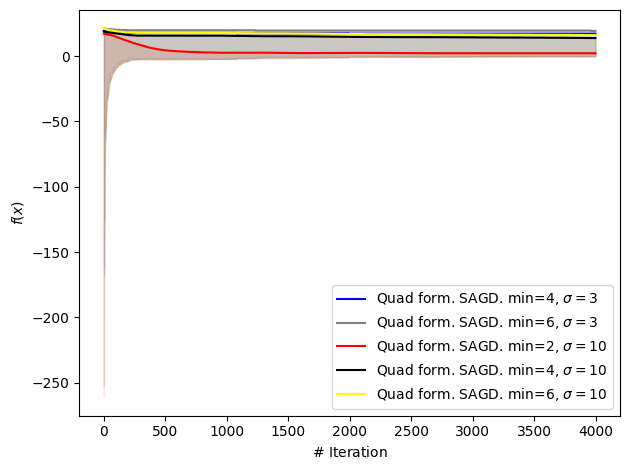

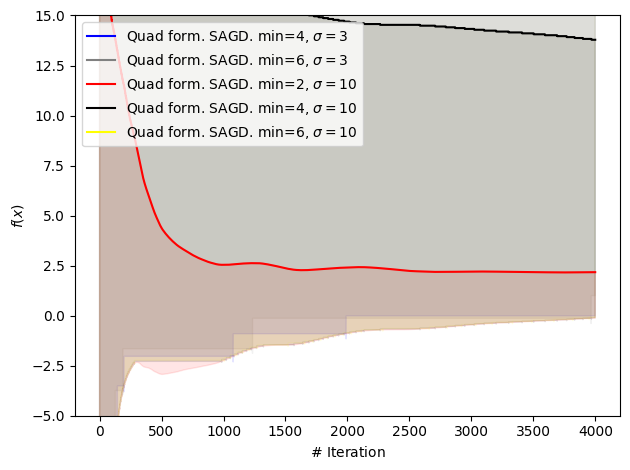

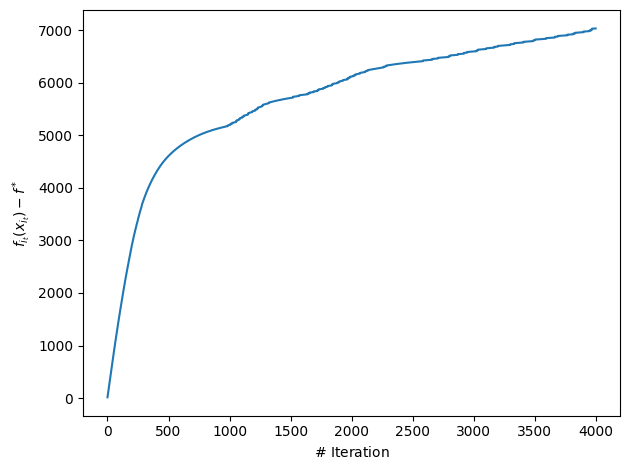

In [38]:
colors = ["b", "gray", "r", "black", "yellow"]

figs = {}

figs["running"] = alg_res.draw_all_steps(arms, colors=colors)
figs["running_clipped"] = alg_res.draw_all_steps(arms, colors=colors, ylim=[-5, 15])
figs["cumulative"] = alg_res.draw_cumulative_regret(2)

In [24]:
import os


savepath = Path("../exp_results/figures")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath / "stochastic"
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name)